# Recherche des meilleures données labellisées avec FixMatch

In [ ]:
# Import
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

# Data Loading

In [ ]:
from tensorflow.keras.datasets import mnist

def generate_mnist_dataset():

  # Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
  x_test = np.expand_dims(x_test.astype('float32') / 255., 3)

  return x_train, y_train, x_test, y_test


# Model


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

def create_model_mnist():

  inputs = Input(shape=(28,28,1))

  x = Conv2D(6,5,activation = 'relu')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(16,5,activation = 'relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(120,activation='relu')(x)
  x = Dense(84,activation='relu')(x)

  outputs = Dense(10,activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

# Best label with Model Confidence

In [ ]:
# Charger les données
x_train, y_train, x_test, y_test = generate_mnist_dataset()

# Créer et entraîner le modèle
model = create_model_mnist()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1766 - accuracy: 0.9465
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0639 - accuracy: 0.9804
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0476 - accuracy: 0.9852
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0370 - accuracy: 0.9883
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0299 - accuracy: 0.9904


In [ ]:
# Créer un dictionnaire où on va stocker les indices et la confiance associée pour chaque classe
best_indices = {i: [] for i in range(10)}  # 10 pour MNIST
n = 1  # Nombre de données à sélectionner par classe

# Évaluation des prédictions sur x_train
predictions = model.predict(x_train)

# Calculer la confiance pour chaque prédiction
confidence_scores = np.max(predictions, axis=1)

# Vérifier que le label prédit correspond au label réel et stocker la confiance si correct
for idx, (predicted_label, real_label) in enumerate(zip(np.argmax(predictions, axis=1), y_train)):
    if predicted_label == real_label:
        best_indices[real_label].append((idx, confidence_scores[idx]))

# Trier les listes dans le dictionnaire par confiance et garder les n premières
for label in best_indices:
    best_indices[label] = sorted(best_indices[label], key=lambda x: x[1], reverse=True)[:n]

# Extraire les images, les indices et les labels correspondants
top_n_images = []
top_n_labels = []
top_n_indices = []
for label, indices in best_indices.items():
    for idx, _ in indices:
        top_n_images.append(x_train[idx])
        top_n_labels.append(label)
        top_n_indices.append(idx)

top_n_images = np.array(top_n_images)
top_n_labels = np.array(top_n_labels)
top_n_indices = np.array(top_n_indices)

# Afficher les indices des données sélectionnées de dict
print("Meilleurs indices par classe:\n", best_indices)


1875/1875 [==============================] - 6s 3ms/step
Meilleurs indices par classe:
 {0: [(1, 1.0)], 1: [(33646, 0.9999994)], 2: [(25, 1.0)], 3: [(7, 1.0)], 4: [(9, 1.0)], 5: [(47, 1.0)], 6: [(83, 1.0)], 7: [(324, 1.0)], 8: [(31, 1.0)], 9: [(28713, 0.9999994)]}


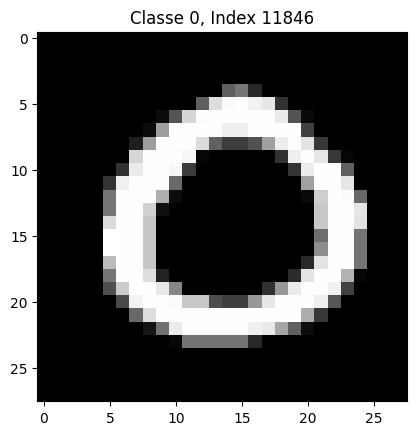

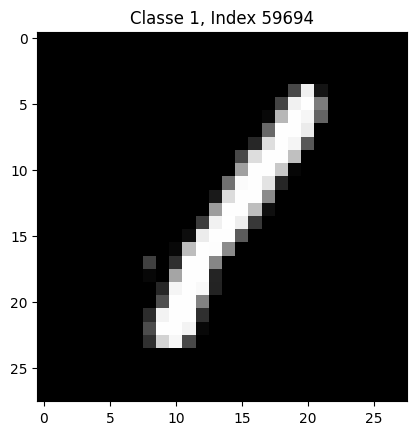

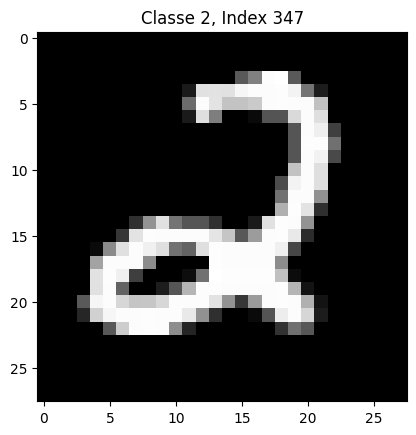

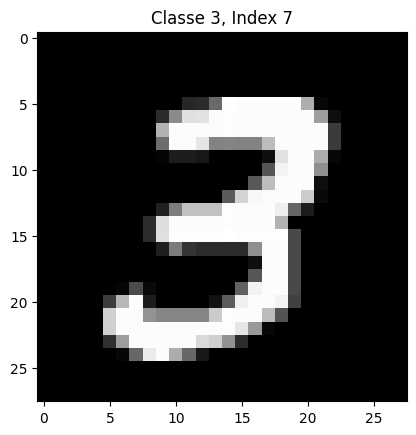

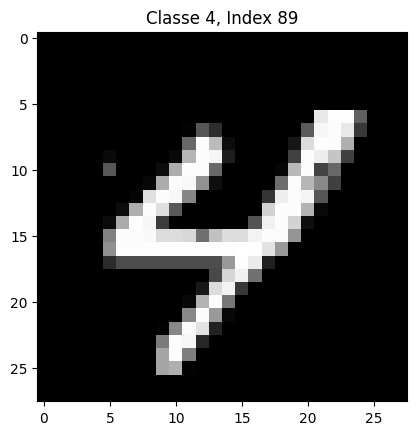

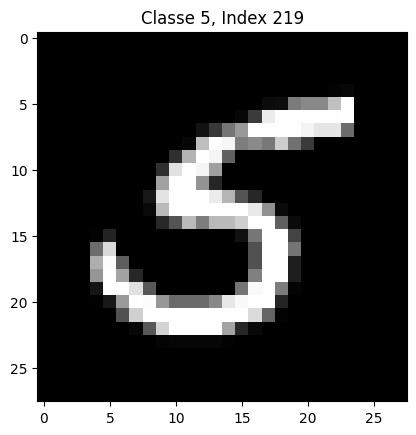

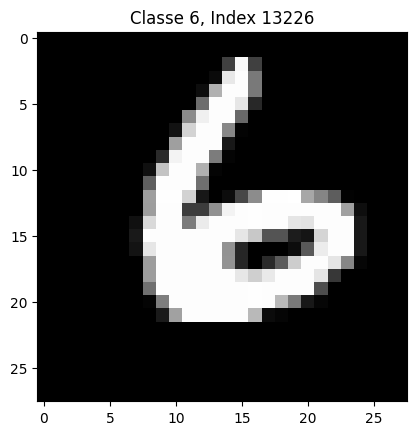

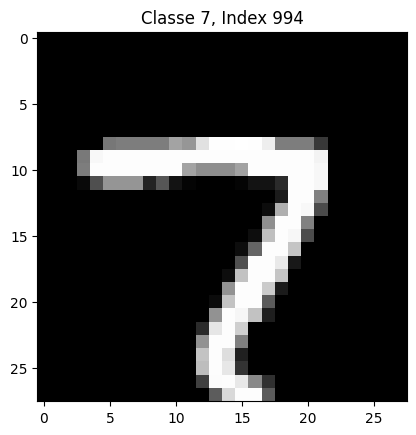

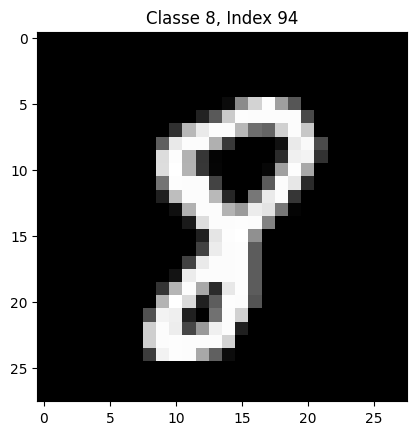

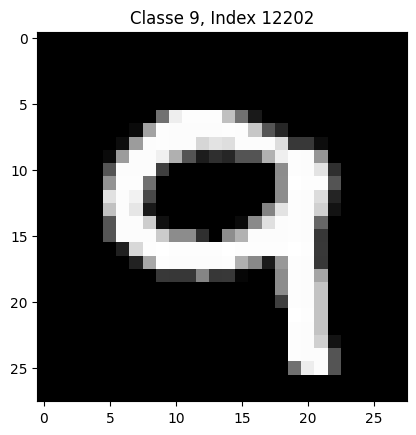

In [ ]:
# Affichage des images sélectionnées
for label, indices in best_indices.items():
    for idx, _ in indices:
        plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Classe {label}, Index {idx}")
        plt.show()

In [ ]:
# Créer un nouveau modèle pour le réentraînement
model_retrained = create_model_mnist()
model_retrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Réentraîner le modèle avec les 10 meilleures données
model_retrained.fit(top_n_images, top_n_labels, epochs=10, batch_size=1)

Epoch 1/10
10/10 [==============================] - 1s 3ms/step - loss: 2.4542 - accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 2.2862 - accuracy: 0.3000
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 2.1626 - accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 2.0676 - accuracy: 0.6000
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 1.8728 - accuracy: 0.7000
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 1.6647 - accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 1.3554 - accuracy: 0.8000
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.9555 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4035 - accuracy: 0.9000


In [ ]:
# Évaluer le modèle original sur l'ensemble de test complet
original_eval = model.evaluate(x_test, y_test)

# Évaluer le modèle réentrainé sur l'ensemble de test complet
retrained_eval = model_retrained.evaluate(x_test, y_test)

print("Évaluation du modèle original : ", original_eval)
print("Évaluation du modèle réentrainé : ", retrained_eval)

313/313 [==============================] - 1s 3ms/step - loss: 1.4639 - accuracy: 0.5460
Évaluation du modèle original :  [0.03641686588525772, 0.9894000291824341]
Évaluation du modèle réentrainé :  [1.4639403820037842, 0.5460000038146973]


In [ ]:
# Sauvegarder un fichier csv avec top_n_images et top_n_labels
np.savetxt(f"top_{n}_images.csv", top_n_images.reshape(-1, 28*28), delimiter=",")
np.savetxt(f"top_{n}_labels.csv", top_n_labels, delimiter=",")
np.savetxt(f"top_{n}_indices.csv", top_n_indices, delimiter=",")

# Best label with Model Confidence using Weak Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_weak = ImageDataGenerator(
    width_shift_range=1.5,
    height_shift_range=1.5
)
data_gen_strong = ImageDataGenerator(
    rotation_range=20, # H: 20 R: 30 #
    width_shift_range=1.5,
    height_shift_range=1.5, # 12,5% of 28 mais modif par rapport aux mesures
    #shear_range=3,
    zoom_range=0.2,
    fill_mode='nearest'
)
# Define a function that weakly augments the images
def weak_augment(images,images_size):
  images = data_gen_weak.flow(images, shuffle=False, batch_size=images_size).next()
  return images

# Define a function that very strongly augments the images
def strong_augment(images,images_size):
  images = data_gen_strong.flow(images, shuffle=False, batch_size=images_size).next()
  return images

In [ ]:
# Charger les données
x_train, y_train, x_test, y_test = generate_mnist_dataset()

# Augmenter les données
x_train_weak = weak_augment(x_train, x_train.shape[0])

# Créer et entraîner le modèle
model = create_model_mnist()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_weak, y_train, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2565 - accuracy: 0.9184
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0885 - accuracy: 0.9726
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0639 - accuracy: 0.9801
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0496 - accuracy: 0.9838
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0392 - accuracy: 0.9872


In [ ]:
# Créer un dictionnaire où on va stocker les indices et la confiance associée pour chaque classe
best_indices = {i: [] for i in range(10)}  # 10 pour MNIST
n = 10  # Nombre de données à sélectionner par classe

# Évaluation des prédictions sur x_train
predictions = model.predict(x_train_weak)

# Calculer la confiance pour chaque prédiction
confidence_scores = np.max(predictions, axis=1)

# Vérifier que le label prédit correspond au label réel et stocker la confiance si correct
for idx, (predicted_label, real_label) in enumerate(zip(np.argmax(predictions, axis=1), y_train)):
    if predicted_label == real_label:
        best_indices[real_label].append((idx, confidence_scores[idx]))

# Trier les listes dans le dictionnaire par confiance et garder les n premières
for label in best_indices:
    best_indices[label] = sorted(best_indices[label], key=lambda x: x[1], reverse=True)[:n]

# Extraire les images, les indices et les labels correspondants
top_n_images = []
top_n_labels = []
top_n_indices = []
for label, indices in best_indices.items():
    for idx, _ in indices:
        top_n_images.append(x_train[idx])
        top_n_labels.append(label)
        top_n_indices.append(idx)

top_n_images = np.array(top_n_images)
top_n_labels = np.array(top_n_labels)
top_n_indices = np.array(top_n_indices)

# Afficher les indices des données sélectionnées de dict
print("Meilleurs indices par classe:\n", best_indices)


1875/1875 [==============================] - 5s 3ms/step
Meilleurs indices par classe:
 {0: [(114, 1.0), (229, 1.0), (249, 1.0), (1078, 1.0), (1386, 1.0), (1502, 1.0), (1530, 1.0), (1723, 1.0), (1769, 1.0), (2147, 1.0)], 1: [(951, 1.0), (8348, 1.0), (16887, 1.0), (24341, 1.0), (32231, 1.0), (35507, 1.0), (43469, 1.0), (47527, 1.0), (57453, 1.0), (3111, 0.9999999)], 2: [(82, 1.0), (347, 1.0), (360, 1.0), (375, 1.0), (378, 1.0), (774, 1.0), (830, 1.0), (1558, 1.0), (1602, 1.0), (1609, 1.0)], 3: [(181, 1.0), (279, 1.0), (695, 1.0), (992, 1.0), (1226, 1.0), (1583, 1.0), (1631, 1.0), (1677, 1.0), (1809, 1.0), (2180, 1.0)], 4: [(9321, 1.0), (19401, 1.0), (23871, 1.0), (40835, 1.0), (43657, 1.0), (50319, 1.0), (2589, 0.9999999), (4513, 0.9999999), (7204, 0.9999999), (10869, 0.9999999)], 5: [(47, 1.0), (219, 1.0), (236, 1.0), (239, 1.0), (266, 1.0), (332, 1.0), (403, 1.0), (474, 1.0), (504, 1.0), (512, 1.0)], 6: [(1488, 1.0), (1494, 1.0), (1637, 1.0), (1892, 1.0), (2153, 1.0), (3869, 1.0), (39

In [ ]:
# Créer un nouveau modèle pour le réentraînement
model_retrained = create_model_mnist()
model_retrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Réentraîner le modèle avec les 10 meilleures données
model_retrained.fit(top_n_images, top_n_labels, epochs=10, batch_size=1)

Epoch 1/10
100/100 [==============================] - 1s 4ms/step - loss: 2.2095 - accuracy: 0.2300
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 1.1908 - accuracy: 0.6100
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.8400
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1220 - accuracy: 0.9600
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9700
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 0s 3ms/step - loss: 9.6553e-04 - accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - 0s 3ms/step - loss: 7.4889e-04 - accuracy

In [ ]:
# Évaluer le modèle original sur l'ensemble de test complet
original_eval = model.evaluate(x_test, y_test)

# Évaluer le modèle réentrainé sur l'ensemble de test complet
retrained_eval = model_retrained.evaluate(x_test, y_test)

print("Évaluation du modèle original : ", original_eval)
print("Évaluation du modèle réentrainé : ", retrained_eval)

313/313 [==============================] - 1s 3ms/step - loss: 0.6838 - accuracy: 0.8221
Évaluation du modèle original :  [0.046600136905908585, 0.9872999787330627]
Évaluation du modèle réentrainé :  [0.6838494539260864, 0.8220999836921692]


In [ ]:
# Sauvegarder un fichier csv avec top_n_images et top_n_labels
np.savetxt(f"top_{n}_images_aug_weak.csv", top_n_images.reshape(-1, 28*28), delimiter=",")
np.savetxt(f"top_{n}_labels_aug_weak.csv", top_n_labels, delimiter=",")
np.savetxt(f"top_{n}_indices_aug_weak.csv", top_n_indices, delimiter=",")

# Best label with Model Confidence using Strong Image Augmentation

In [ ]:
# Charger les données
x_train, y_train, x_test, y_test = generate_mnist_dataset()

# Augmenter les données
# x_train_weak = weak_augment(x_train, x_train.shape[0])
x_train_strong = strong_augment(x_train, x_train.shape[0])

# Créer et entraîner le modèle
model = create_model_mnist()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_strong, y_train, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3213 - accuracy: 0.8968
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1158 - accuracy: 0.9648
Epoch 3/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0869 - accuracy: 0.9733
Epoch 4/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0697 - accuracy: 0.9780
Epoch 5/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0571 - accuracy: 0.9814


In [ ]:
# Créer un dictionnaire où on va stocker les indices et la confiance associée pour chaque classe
best_indices = {i: [] for i in range(10)}  # 10 pour MNIST
n = 10  # Nombre de données à sélectionner par classe

# Évaluation des prédictions sur x_train
predictions = model.predict(x_train_strong)

# Calculer la confiance pour chaque prédiction
confidence_scores = np.max(predictions, axis=1)

# Vérifier que le label prédit correspond au label réel et stocker la confiance si correct
for idx, (predicted_label, real_label) in enumerate(zip(np.argmax(predictions, axis=1), y_train)):
    if predicted_label == real_label:
        best_indices[real_label].append((idx, confidence_scores[idx]))

# Trier les listes dans le dictionnaire par confiance et garder les n premières
for label in best_indices:
    best_indices[label] = sorted(best_indices[label], key=lambda x: x[1], reverse=True)[:n]

# Extraire les images et les labels correspondants
top_n_images = []
top_n_labels = []
for label, indices in best_indices.items():
    for idx, _ in indices:
        top_n_images.append(x_train_strong[idx])
        top_n_labels.append(label)

# Recueillir les indices des données sélectionnées
top_n_indices = []
for label, indices in best_indices.items():
    for idx, _ in indices:
        top_n_indices.append(idx)

top_n_images = np.array(top_n_images)
top_n_labels = np.array(top_n_labels)

# Afficher les indices des données sélectionnées de dict
print("Meilleurs indices par classe:\n", best_indices)


1875/1875 [==============================] - 9s 5ms/step
Meilleurs indices par classe:
 {0: [(303, 1.0), (458, 1.0), (1530, 1.0), (2253, 1.0), (2532, 1.0), (3328, 1.0), (3702, 1.0), (5010, 1.0), (5487, 1.0), (5884, 1.0)], 1: [(42911, 0.99999917), (31971, 0.99999905), (13501, 0.9999989), (44996, 0.9999988), (37650, 0.9999987), (26096, 0.99999845), (40604, 0.99999845), (58260, 0.99999845), (38837, 0.99999833), (55046, 0.99999833)], 2: [(10945, 1.0), (16057, 1.0), (20007, 1.0), (56264, 1.0), (378, 0.9999999), (3647, 0.9999999), (10567, 0.9999999), (10959, 0.9999999), (18804, 0.9999999), (33342, 0.9999999)], 3: [(27, 1.0), (107, 1.0), (111, 1.0), (179, 1.0), (215, 1.0), (255, 1.0), (279, 1.0), (298, 1.0), (341, 1.0), (361, 1.0)], 4: [(797, 1.0), (1187, 1.0), (1705, 1.0), (2589, 1.0), (2983, 1.0), (4035, 1.0), (4055, 1.0), (4798, 1.0), (8101, 1.0), (8677, 1.0)], 5: [(332, 1.0), (1382, 1.0), (2279, 1.0), (2755, 1.0), (2857, 1.0), (4670, 1.0), (6712, 1.0), (7591, 1.0), (8766, 1.0), (9111, 1.0

In [ ]:
# Créer un nouveau modèle pour le réentraînement
model_retrained = create_model_mnist()
model_retrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Réentraîner le modèle avec les 10 meilleures données
model_retrained.fit(top_n_images, top_n_labels, epochs=10, batch_size=1)

Epoch 1/10
100/100 [==============================] - 2s 4ms/step - loss: 2.2473 - accuracy: 0.2100
Epoch 2/10
100/100 [==============================] - 0s 5ms/step - loss: 1.1561 - accuracy: 0.6100
Epoch 3/10
100/100 [==============================] - 1s 5ms/step - loss: 0.2874 - accuracy: 0.9200
Epoch 4/10
100/100 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9300
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9800
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - 1s 7ms/step - loss: 9.6854e-04 - accuracy: 1.

In [ ]:
# Évaluer le modèle original sur l'ensemble de test complet
original_eval = model.evaluate(x_test, y_test)

# Évaluer le modèle réentrainé sur l'ensemble de test complet
retrained_eval = model_retrained.evaluate(x_test, y_test)

print("Évaluation du modèle original : ", original_eval)
print("Évaluation du modèle réentrainé : ", retrained_eval)

313/313 [==============================] - 1s 1ms/step - loss: 1.1078 - accuracy: 0.7539
Évaluation du modèle original :  [0.03200683370232582, 0.9891999959945679]
Évaluation du modèle réentrainé :  [1.1077637672424316, 0.7538999915122986]


In [ ]:
# Sauvegarder un fichier csv avec top_n_images et top_n_labels
np.savetxt(f"top_{n}_images_aug_strong.csv", top_n_images.reshape(-1, 28*28), delimiter=",")
np.savetxt(f"top_{n}_labels_aug_strong.csv", top_n_labels, delimiter=",")
np.savetxt(f"top_{n}_indices_aug_strong.csv", top_n_indices, delimiter=",")

# Conclusion

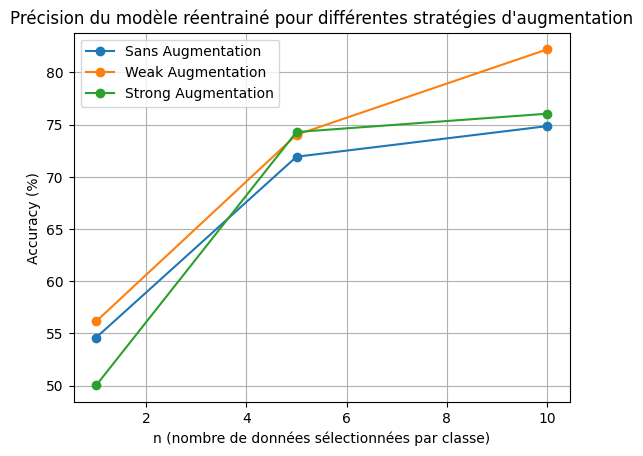

In [ ]:
# Accuracy plot, for the best results of each exemple
n = [1, 5, 10]
accuracy_sans_aug = [54.60, 71.93, 74.86]
accuracy_weak_aug = [56.15, 74.03, 82.21]
accuracy_strong_aug = [50.02, 74.30, 76.05]

plt.figure()
plt.plot(n, accuracy_sans_aug, marker='o', label='Sans Augmentation')
plt.plot(n, accuracy_weak_aug, marker='o', label='Weak Augmentation')
plt.plot(n, accuracy_strong_aug, marker='o', label='Strong Augmentation')
plt.title('Précision du modèle réentrainé pour différentes stratégies d\'augmentation')
plt.xlabel('n (nombre de données sélectionnées par classe)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

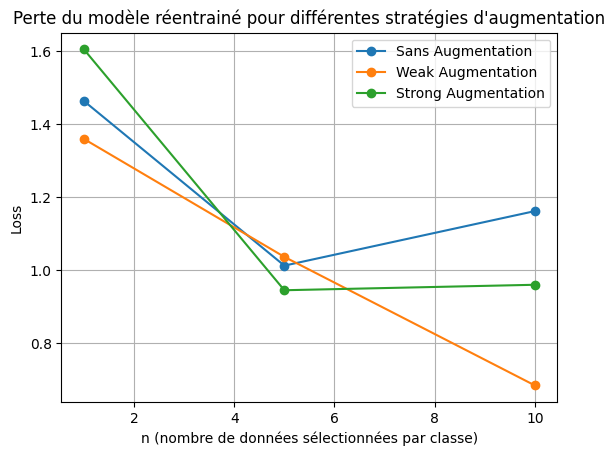

In [ ]:
loss_sans_aug = [1.4639, 1.0124, 1.1620]
loss_weak_aug = [1.3599, 1.0364, 0.6838]
loss_strong_aug = [1.6055, 0.9449, 0.9599]

plt.figure()
plt.plot(n, loss_sans_aug, marker='o', label='Sans Augmentation')
plt.plot(n, loss_weak_aug, marker='o', label='Weak Augmentation')
plt.plot(n, loss_strong_aug, marker='o', label='Strong Augmentation')
plt.title('Perte du modèle réentrainé pour différentes stratégies d\'augmentation')
plt.xlabel('n (nombre de données sélectionnées par classe)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()